# SFI 2022 Homework - Kesong and Shayla

## Question

```
Consider the following situation:

An organization starts to encourage its employees to report when things go wrong.

Model, using whatever techniques you wish, the above scenario.
Explicitly state your model and key assumptions.
Summarize key results.
Suggest some potentially interesting future directions and questions for the model.
Suggest some standard social science scenarios that could be usefully modeled using such a process.
```

Source: [Santa Fe Institute Graduate Workshop in Complexity and Computational Modeling, Homework Problem (2022)](http://jhmsfi.com/econ/homework22.html)  
<br />

### Authors

[Kesong Cao](https://kesong.dev), Cognitive Psychology PhD student, University of Wisconsin-Madison   
[Shayla Olson](https://shaylafolson.org/), Political Science PhD student, University of Michigan

## Basic Model

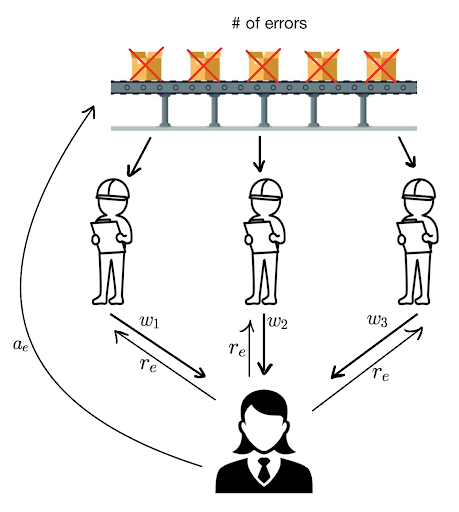

Imagine a factory with employees working collaboratively on some product, where all employees contribute to the creation of some product. In production, there are a number (5) of errors that exist, but at time 0, there are no reports of these errors. Our basic setup is an agent-based model with three employees and one boss. The employees have some probability of reporting errors, and the boss has some probability of investigating or ignoring error reports and providing positive or negative reinforcement to the employee.

Our desired outcomes are based on our interpretation of the prompt, to *encourage* error reports. As such, our first goal is to maximize reporting probability for all employees. Second, we expect that the organization would like to correct and reduce these errors and we seek to minimize the total number of errors.

For time period, $t$: <br>

$E_t = E_{t-1} + \sum_{e = 1}^{n}a_{et} + \epsilon_t$, <br>

where $E_t$ is the total number of errors, $E_{t-1}$ is the total errors in the previous time period, $a_{et}$ is the boss's reaction to each reported error $e$ in that time period, summed over the total number of errors $n$ reported in the round, and $\epsilon$ is a random number of errors introduced at the beginning of the round.

The boss's choice of whether to investigate is currently fixed at $Pr($Investigate$) = 0.8$. We present our model results for three levels of probability for positive reinforcement - 0.05, 0.50, and 0.99.

The number of reported errors each round depend on each employee's choice whether to report an error or not. For each employee: <br>

$w_{t} = w_{t-1} + \sum_{e = 1}^{n}r_{e[t-1]}$,

where $w_{t}$ is the probability of reporting an error in the current time period. This is determined by the employee's probability of reporting in the previous round and the boss's chosen reinforcement for each error in the previous round, $r_{e[t-1]}$.

If the boss chooses to investigate a given error within a round, $a_e = -1$. If the boss chooses not to investigate a given error, $a_e$ changes with some value drawn from a normal distribution $N(0.5, 1)$.

If the boss chooses positive reinforcement for a given error, $r_{e[t-1]} = 0.01$. If the boss chooses negative reinforcement, $r_{e[t-1]} = -0.01$ We do currently limit the values of $w_t$ to run between zero and one, so there is some diminishing effect of constant positive and constant negative reports.

### Assumptions
Our model comes with a number of assumptions, many of which we envision will be future extensions.
1. All employees have equal and inseparable contributions to product and errors.
2. All employees can observe all errors.
3. Bosses only respond to errors that are reported. <br>
    *Since bosses only respond to reported errors, they do not punish or reward the difference between reported and actual errors.*
4. Boss responds equally to all employees.
5. All employees observe and are equally, but independently impacted by the boss’s response to each error.
6. All reported errors are true errors.
7. Employees can only report one error each time period.
8. Errors are equivalent in severity.
9. Each error is only reported once per time period, so the number of reported errors can not exceed the total number of errors.

Finally, right now the boss and employees have no utility functions and are not learning agents. All transitions are either deterministic or stochastic under some fixed probability distribution.

In [1]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

ERROR_BASELINE = 5
ERROR_CHANGE_INVESTIGATE = -1
ERROR_CHANGE_NOT_INVESTIGATE = scipy.stats.norm(0.5, 1).rvs()

POS_REINFORCEMENT = .1
NEG_REINFORCEMENT = -.1
PROB_INVESTIGATE = .8
PROB_POSITIVE_REINF = .5 # .4 -> stop reporting; .8 -> always reporting
DEBUG_PRINT = False

def cap_prob(prob):
    if prob > 1:
        return 1
    elif prob < 0:
        return 0
    else:
        return prob

class Employee:
    def __init__(self, env, prob_report = .5):
        self.env = env
        self.prob_report = prob_report
        # self.prob_not_report = 1 - self.prob_report

    def decide_report(self):
        self.prob_report = cap_prob(self.prob_report)
        rv = scipy.stats.uniform(0, 1).rvs()
        if rv < self.prob_report:
            if env.errors != 0:
                self.env.reports += 1
            else:
                return # TO CHANGE
        else:
            return # TO CHANGE

    def decide(self):
        self.decide_report()

class Boss:
    def __init__(self, env):
        self.env = env
        self.prob_investigate = PROB_INVESTIGATE # toy values for now
        # self.prob_not_investigate = 1 - self.prob_investigate
        self.prob_positive_reinf = PROB_POSITIVE_REINF # toy values for now
        # self.prob_negative_reinf = 1 - self.prob_positive_reinf

    def decide_reinforcement(self, employees: [Employee]):
        self.prob_positive_reinf = cap_prob(self.prob_positive_reinf)
        rv = scipy.stats.uniform(0, 1).rvs()
        if rv < self.prob_positive_reinf:
            if self.env.debug_print:
                print("POSITIVE REINF")
            for employee in employees:
                employee.prob_report += POS_REINFORCEMENT
                employee.prob_report = cap_prob(employee.prob_report)
        else:
            if self.env.debug_print:
                print("NEGATIVE REINF")
            for employee in employees:
                employee.prob_report += NEG_REINFORCEMENT
                employee.prob_report = cap_prob(employee.prob_report)

    
    def decide_investigate(self):
        self.prob_investigate = cap_prob(self.prob_investigate)
        rv = scipy.stats.uniform(0, 1).rvs()
        if rv < self.prob_investigate:
            if self.env.debug_print:
                print("INVESTIGATE")
            env.errors += ERROR_CHANGE_INVESTIGATE
        else:
            if self.env.debug_print:
                print("NOT INVESTIGATE")
            env.errors += ERROR_CHANGE_NOT_INVESTIGATE
    
    def decide(self):
        self.decide_investigate()
        self.decide_reinforcement(env.employees)


class Environment:
    def __init__(self, debug_print=DEBUG_PRINT):
        # self.num_boss = 1
        self.debug_print = debug_print
        self.errors = ERROR_BASELINE
        self.reports = 0
        self.num_employee = 3
        self.boss = Boss(self)
        self.employees = [
            Employee(self, .1),
            Employee(self, .5),
            Employee(self, 1)
        ]
        if self.debug_print:
            for i, employee in enumerate(self.employees):
                print("Employee", i, "'s rate of reporting:", employee.prob_report)
            print("Initial errors:", self.errors, "\n")
        self.total_values = [
            [self.errors, *[employee.prob_report for employee in self.employees]]
        ]
    
    def step(self):
        self.reports = 0 
        for employee in self.employees:
            employee.decide()
        if self.debug_print:
            print("Num of reports in this step:", self.reports)
        for _ in range(self.reports):
            self.boss.decide()
        if self.errors < 0:
            self.errors = 0
        if self.debug_print:
            for i, employee in enumerate(self.employees):
                print("Employee", i, "'s rate of reporting:", employee.prob_report)
            print("Num of errors remaining after this step:", self.errors, "\n")
        self.total_values.append(
            [self.errors, *[employee.prob_report for employee in self.employees]]
        )
        self.errors += np.random.randint(4) # add random error each round

    def output_values(self):
        return np.array(self.total_values).T

## Results

We display results for 100 time steps. Keeping other parameters fixed, with a low (.05) probability of positive reinforcement by the boss when dealing with an error report, all employees stop reporting, eventually ending up with zero probability of reporting an error. Errors continue to increase. With a high (.99) probability of positive reinforcement, all employees always report, ending up with 100% probability of reporting an error. With a medium probability (in between .05 and .99), reporting rates are not converged but are decreasing and errors increase. The threshold of positive reinforcement required to ensure employees report is quite high (~0.9 for 100 time periods).

In [2]:
PROB_POSITIVE_REINF = .5
NUM_STEPS = 100
env = Environment()
for _ in range(NUM_STEPS):
    env.step()
out_50 = env.output_values()

out_50[:,-1]

PROB_POSITIVE_REINF = .05
NUM_STEPS = 100
env = Environment()
for _ in range(NUM_STEPS):
    env.step()
out_05 = env.output_values()

out_05[:,-1]

PROB_POSITIVE_REINF = .99
NUM_STEPS = 100
env = Environment()
for _ in range(NUM_STEPS):
    env.step()
out_99 = env.output_values()

out_99[:,-1]

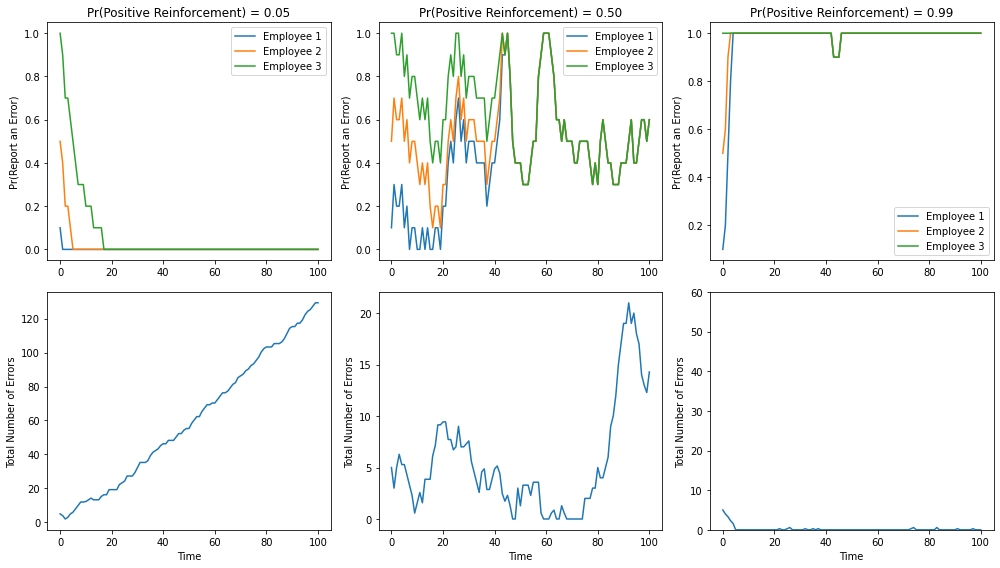

In [3]:
fig = plt.figure(figsize= [14, 8])

# 0.05
plt.subplot(2, 3, 1)
for _j in range(1, 4):
    plt.plot([_i for _i in range(NUM_STEPS+1)], out_05[_j,:], label="Employee "+str(_j))
plt.legend()
#plt.xlabel("Time"+", PROB_POSITIVE_REINF = "+str(PROB_POSITIVE_REINF))
plt.ylabel("Pr(Report an Error)")
plt.title("Pr(Positive Reinforcement) = 0.05")
plt.subplot(2, 3, 4)
plt.plot([_i for _i in range(NUM_STEPS+1)], out_05[0,:])
plt.xlabel("Time")
plt.ylabel("Total Number of Errors")

# 0.5
plt.subplot(2, 3, 2)
for _j in range(1, 4):
    plt.plot([_i for _i in range(NUM_STEPS+1)], out_50[_j,:], label="Employee "+str(_j))
plt.legend()
#plt.xlabel("Time"+", PROB_POSITIVE_REINF = "+str(PROB_POSITIVE_REINF))
plt.ylabel("Pr(Report an Error)")
plt.title("Pr(Positive Reinforcement) = 0.50")
plt.subplot(2, 3, 5)
plt.plot([_i for _i in range(NUM_STEPS+1)], out_50[0,:])
plt.xlabel("Time")
plt.ylabel("Total Number of Errors")

# 0.99
plt.subplot(2, 3, 3)
for _j in range(1, 4):
    plt.plot([_i for _i in range(NUM_STEPS+1)], out_99[_j,:], label="Employee "+str(_j))
plt.legend()
#plt.xlabel("Time"+", PROB_POSITIVE_REINF = "+str(PROB_POSITIVE_REINF))
plt.ylabel("Pr(Report an Error)")
plt.title("Pr(Positive Reinforcement) = 0.99")
plt.subplot(2, 3, 6)
plt.plot([_i for _i in range(NUM_STEPS+1)], out_99[0,:])
plt.ylim([0, 60])
plt.xlabel("Time")
plt.ylabel("Total Number of Errors")

plt.tight_layout()

plt.show()

In [4]:
# PROB_POSITIVE_REINF = .05 # .4 -> stop reporting; .8 -> always reporting
# for _it in range(100):
#     env = Environment()
#     for _ in range(100):
#         env.step()
#     out = env.output_values()

#     if np.any(out[1:,-1] > .01):
#         print("NOT CONVERGED", _it)

In [44]:
# PROB_POSITIVE_REINF = .99 # .2 -> stop reporting; .8 -> always reporting
# for _it in range(100):
#     env = Environment()
#     for _ in range(100):
#         env.step()
#     out = env.output_values()

#     if np.any(out[1:,-1] < .99):
#         print("NOT CONVERGED", _it)

## Extensions

Possible extensions for our model include many changes to the boss's reinforcement behavior, such as:
1. Respond to only employees who report either positively or negatively.
2. Respond to employees who report at some level, and all other employees who did not report receive some spillover response. For example, if reporters receive a reward of 0.01 for positive reinforcement, nonreporters would receive a reward of $s*0.01, s<0.01$.
3. Reward reporters and punish nonreporters.
4. Punish reporters and do nothing to nonreporters.
5. Punish all employees for any unreported errors (employees would need to be able to report as many errors as exist).
6. The boss could adapt her behavior – if positive[negative] reinforcement leads to lower errors, the boss increases probability of positive[negative] reinforcement. The boss could also used mixed, adaptive reinforcement.

Regarding the boss's choice to investigate errors or not:
1. The boss could investigate more if the total number of errors is decreasing, suggesting the investigations are working.
2. If the number of errors is always increasing, the boss may give up on investigating.

We could also add new layers, such as viewing the employees as an assembly line. For example, the first employee will choose whether to report the error to the next employee in line. That employee also makes a decision to report down the line. Then, the probability of errors being reported depend on the subsequent actions of the employees. Another option would be to add other layers of management. For example, a middle management would act similar to the boss in our model, and a "big boss" would respond to that manager while only observing the total number of errors. We could also add weight to the errors, where some errors have higher probability of being reported and/or investigated, perhaps because they are more urgent.

Finally, we could introduce an element of interaction between employees in the form of responsibility and blame. In this case, employees would be individually responsible for committing some amount of errors and can choose to report their own errors or report their coworkers' errors. We could also introduce a probability of fixing errors before reporting them. The boss's behavior could be determined by whether the reported error was committed by the reporting employee or by another employee, either rewarding/punishing an employee for taking responsibility for their own errors and/or rewarding/punishing employees that report their coworkers.

## Social Science Applications
### Reporting Harassment
One possible application of this model is to reporting harassment to the police. In this scenario, victims of harassment and bystanders can report harassment, and the police choose to investigate the harassment and respond in some way to the reporter.
The police officer:
- Can choose to investigate or not investigate
- Can choose to be supportive of the reporter or not supportive

If the police officer is supportive:
- More people report harassment.
- Harassment decreases (Assuming perpetrators respond to punitive action.)

If police officer is not supportive:
- Less people come forward with harassment.
- Harassment continues or increases.

### Internet Censorship
Social media sites are heavily censored (at least) in China, e.g. Sina Microblog, WeChat articles. Chinese government enforces strict anti-anonymous policy and each (!) post is auto censored before posting and subject to removal after posting. The behavior of netizens choosing to report a post or not, and whether it is encouraged by the government, would be an interesting research idea in my opinion.

## Appendix: code of our model

In [5]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt

ERROR_BASELINE = 5
ERROR_CHANGE_INVESTIGATE = -1
ERROR_CHANGE_NOT_INVESTIGATE = scipy.stats.norm(0.5, 1).rvs()

POS_REINFORCEMENT = .1
NEG_REINFORCEMENT = -.1
PROB_INVESTIGATE = .8
PROB_POSITIVE_REINF = .5 # .4 -> stop reporting; .8 -> always reporting
DEBUG_PRINT = False

def cap_prob(prob):
    if prob > 1:
        return 1
    elif prob < 0:
        return 0
    else:
        return prob

class Employee:
    def __init__(self, env, prob_report = .5):
        self.env = env
        self.prob_report = prob_report
        # self.prob_not_report = 1 - self.prob_report

    def decide_report(self):
        self.prob_report = cap_prob(self.prob_report)
        rv = scipy.stats.uniform(0, 1).rvs()
        if rv < self.prob_report:
            if env.errors != 0:
                self.env.reports += 1
            else:
                return # TO CHANGE
        else:
            return # TO CHANGE

    def decide(self):
        self.decide_report()

class Boss:
    def __init__(self, env):
        self.env = env
        self.prob_investigate = PROB_INVESTIGATE # toy values for now
        # self.prob_not_investigate = 1 - self.prob_investigate
        self.prob_positive_reinf = PROB_POSITIVE_REINF # toy values for now
        # self.prob_negative_reinf = 1 - self.prob_positive_reinf

    def decide_reinforcement(self, employees: [Employee]):
        self.prob_positive_reinf = cap_prob(self.prob_positive_reinf)
        rv = scipy.stats.uniform(0, 1).rvs()
        if rv < self.prob_positive_reinf:
            if self.env.debug_print:
                print("POSITIVE REINF")
            for employee in employees:
                employee.prob_report += POS_REINFORCEMENT
                employee.prob_report = cap_prob(employee.prob_report)
        else:
            if self.env.debug_print:
                print("NEGATIVE REINF")
            for employee in employees:
                employee.prob_report += NEG_REINFORCEMENT
                employee.prob_report = cap_prob(employee.prob_report)

    
    def decide_investigate(self):
        self.prob_investigate = cap_prob(self.prob_investigate)
        rv = scipy.stats.uniform(0, 1).rvs()
        if rv < self.prob_investigate:
            if self.env.debug_print:
                print("INVESTIGATE")
            env.errors += ERROR_CHANGE_INVESTIGATE
        else:
            if self.env.debug_print:
                print("NOT INVESTIGATE")
            env.errors += ERROR_CHANGE_NOT_INVESTIGATE
    
    def decide(self):
        self.decide_investigate()
        self.decide_reinforcement(env.employees)


class Environment:
    def __init__(self, debug_print=DEBUG_PRINT):
        # self.num_boss = 1
        self.debug_print = debug_print
        self.errors = ERROR_BASELINE
        self.reports = 0
        self.num_employee = 3
        self.boss = Boss(self)
        self.employees = [
            Employee(self, .1),
            Employee(self, .5),
            Employee(self, 1)
        ]
        if self.debug_print:
            for i, employee in enumerate(self.employees):
                print("Employee", i, "'s rate of reporting:", employee.prob_report)
            print("Initial errors:", self.errors, "\n")
        self.total_values = [
            [self.errors, *[employee.prob_report for employee in self.employees]]
        ]
    
    def step(self):
        self.reports = 0 
        for employee in self.employees:
            employee.decide()
        if self.debug_print:
            print("Num of reports in this step:", self.reports)
        for _ in range(self.reports):
            self.boss.decide()
        if self.errors < 0:
            self.errors = 0
        if self.debug_print:
            for i, employee in enumerate(self.employees):
                print("Employee", i, "'s rate of reporting:", employee.prob_report)
            print("Num of errors remaining after this step:", self.errors, "\n")
        self.total_values.append(
            [self.errors, *[employee.prob_report for employee in self.employees]]
        )
        self.errors += np.random.randint(4) # add random error each round

    def output_values(self):
        return np.array(self.total_values).T